# Create plots
This notebook as the name suggests, creates potential plots to be used in the paper! Once we decided on the plots we like, I'll create separate python functions for the repo.


In [1]:
import glob
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p3quxluy because the default path (/ifs/home/jls106_gp/nhw2114/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 20240316_run
This is the latest (and hopefully last run) of simulations and performance metrics.

In [2]:
in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240316_run/"

eakf_metrics_df = pd.read_csv(in_dir + 'eakf_metrics_all.csv')
epiestim_metrics_df = pd.read_csv(in_dir + 'epiEstim_metrics_all.csv')


## Table 2 and 3
This section prints out LaTeX code that can be copied into the overleaf file for tables 2 and 3.

In [9]:
def compute_ci(df, by_col):
    
    mean_df = df.groupby(by_col).mean()
    median_df = df.groupby(by_col).median()
    std_df = df.groupby(by_col).std()
    n_df = df.groupby(by_col).count()

    lower_df = df.groupby(by_col).quantile(q=0.025)
    upper_df = df.groupby(by_col).quantile(q=0.975)
    
    # add suffixes
    lower_df = lower_df.add_suffix('_lower')
    upper_df = upper_df.add_suffix('_upper')
    mean_df = mean_df.add_suffix('_mean')
    median_df = median_df.add_suffix('_median')
    # merge
    merge_df = lower_df.merge(mean_df, on=by_col)
    merge_df = merge_df.merge(upper_df, on=by_col)
    merge_df = merge_df.merge(median_df, on=by_col)
    
    return merge_df

def dataframe_to_latex(df, columns, titles, metric_dict=None, degree=2):
    """
    Convert a Pandas DataFrame with mean, lower, and upper columns to a LaTeX table.

    Parameters:
    - df: Pandas DataFrame.
    - columns: Columns of table.

    Returns:
    - LaTeX table string.
    """
    df = df[list(titles.keys())]
    # Column row
    tab_arg = "l|" * len(columns)
    latex_table = "\ begin{tabular}{|" + tab_arg + "} \hline "
    latex_table += " & ".join([titles[col] for col in df.columns])
    latex_table += " \\\\\n \hline "
    # Data rows
    for metric, title in metric_dict.items():
        latex_table += f"{title} & "
        
        mean = df.loc[df.metric == metric + "_mean"].round(degree).values.tolist()[0]
        lower = df.loc[df.metric == metric + "_lower"].round(degree).values.tolist()[0]
        upper = df.loc[df.metric == metric + "_upper"].round(degree).values.tolist()[0]
        median = df.loc[df.metric == metric + "_median"].round(degree).values.tolist()[0]
        latex_table += " &  ".join(
            [f"{mean[i]} ({lower[i]}, {upper[i]}) " for i in range(1,len(mean))]
        )
        latex_table += " \\\\\n \hline "
    
    latex_table += "\end{tabular}"

    return latex_table

In [10]:
# epiestim_metrics_df.drop(['colname.x', 'colname.y'], axis=1, inplace=True)
eakf_stats_df = compute_ci(eakf_metrics_df, "method")
epiestim_stats_df = compute_ci(epiestim_metrics_df, "window")

In [11]:
cols_for_table1 = ['metric', 'adaptive inflation', 'fixed inflation', 'no inflation', 'smooth inflation', 8]

metric_title_dict = {
    'in_ci_last_epi_day' : 'True $R_t$ within 95\% CI',
    'rt_rmse_last_epi_day' : '$R_t$ RMSE',
    'avg_w2_last_epi_day' : '$W_2(p,q)$',
    'avg_kl_last_epi_day' : '$D_{KL}(p || q)$',
    'crps_last_epi_day' : 'CRPS',
}
metric_title_first_dict = {
    'in_ci_first_epi_day' : 'True $R_t$ within 95\% CI',
    'rt_rmse_first_epi_day' : '$R_t$ RMSE',
    'avg_w2_first_epi_day' : '$W_2(p,q)$',
    'avg_kl_first_epi_day' : '$D_{KL}(p || q)$',
    'crps_first_epi_day' : 'CRPS',
}
col_title_dict = {
    'metric' : 'Metric',
    'no inflation' : 'no inflation',
    'fixed inflation' : 'fixed inflation',
    'adaptive inflation' : 'adaptive inflation',
    'smooth inflation' : 'EnSRS adaptive inflation', 
    8 : 'EpiEstim',
}
transpose_df = eakf_stats_df.T.reset_index().rename(columns={'index':'metric'})
epi_transpose_df = epiestim_stats_df[epiestim_stats_df.index == 8].T.reset_index().rename(columns={'index':'metric'})
transpose_df = transpose_df.merge(epi_transpose_df, on="metric")
print(dataframe_to_latex(transpose_df, cols_for_table1, col_title_dict, metric_title_dict))

\ begin{tabular}{|l|l|l|l|l|l|} \hline Metric & no inflation & fixed inflation & adaptive inflation & EnSRS adaptive inflation & EpiEstim \\
 \hline True $R_t$ within 95\% CI & 0.0 (0.0, 0.0)  &  0.43 (0.0, 1.0)  &  0.83 (0.0, 1.0)  &  0.83 (0.0, 1.0)  &  0.84 (0.0, 1.0)  \\
 \hline $R_t$ RMSE & 2.56 (1.1, 3.62)  &  0.62 (0.07, 2.8)  &  0.26 (0.08, 1.07)  &  0.26 (0.08, 1.07)  &  1.78 (0.79, 3.46)  \\
 \hline $W_2(p,q)$ & 0.39 (0.01, 0.94)  &  0.47 (0.02, 1.85)  &  0.16 (0.02, 0.56)  &  0.22 (0.01, 0.77)  &  0.28 (0.01, 0.81)  \\
 \hline $D_{KL}(p || q)$ & 4.06 (0.11, 12.83)  &  1.15 (0.04, 7.55)  &  0.3 (0.03, 2.0)  &  1.02 (0.05, 6.44)  &  1.48 (0.04, 7.79)  \\
 \hline CRPS & 0.83 (0.27, 1.9)  &  0.67 (0.19, 1.66)  &  0.53 (0.14, 1.27)  &  0.7 (0.22, 1.99)  &  5.87 (3.95, 7.54)  \\
 \hline \end{tabular}


In [12]:
print(dataframe_to_latex(transpose_df, cols_for_table1, col_title_dict, metric_title_first_dict))

\ begin{tabular}{|l|l|l|l|l|l|} \hline Metric & no inflation & fixed inflation & adaptive inflation & EnSRS adaptive inflation & EpiEstim \\
 \hline True $R_t$ within 95\% CI & 0.0 (0.0, 0.0)  &  0.37 (0.0, 1.0)  &  0.78 (0.0, 1.0)  &  0.51 (0.0, 1.0)  &  0.31 (0.0, 1.0)  \\
 \hline $R_t$ RMSE & 0.44 (0.2, 0.99)  &  0.48 (0.21, 0.99)  &  0.55 (0.16, 1.53)  &  0.38 (0.05, 1.03)  &  0.78 (0.11, 2.18)  \\
 \hline $W_2(p,q)$ & 0.72 (0.18, 1.51)  &  0.61 (0.07, 1.35)  &  0.39 (0.04, 1.13)  &  0.33 (0.07, 0.78)  &  1.09 (0.19, 1.88)  \\
 \hline $D_{KL}(p || q)$ & 2.0 (0.2, 10.32)  &  1.29 (0.06, 6.02)  &  0.56 (0.03, 2.64)  &  0.3 (0.05, 1.04)  &  6.25 (0.1, 22.55)  \\
 \hline CRPS & 5.51 (0.13, 35.54)  &  5.34 (0.11, 37.59)  &  4.2 (0.09, 31.83)  &  29.36 (0.39, 115.51)  &  47.16 (0.62, 263.81)  \\
 \hline \end{tabular}


In [13]:
transpose_df.loc[transpose_df.metric.isin([k + '_mean' for k in list(metric_title_first_dict.keys())])]

,metric,adaptive inflation,fixed inflation,no inflation,smooth inflation,8
26,rt_rmse_first_epi_day_mean,0.547531,0.480939,0.444331,0.379630,0.779492
28,avg_w2_first_epi_day_mean,0.388899,0.610557,0.718550,0.330305,1.088273
30,avg_kl_first_epi_day_mean,0.562223,1.285810,1.997526,0.296407,6.250043
31,in_ci_first_epi_day_mean,0.779713,0.367985,0.000000,0.513201,0.306156
32,crps_first_epi_day_mean,4.200745,5.337257,5.512691,29.363174,47.155433


In [14]:
transpose_df.loc[transpose_df.metric.isin([k + '_mean' for k in list(metric_title_dict.keys())])]

,metric,adaptive inflation,fixed inflation,no inflation,smooth inflation,8
18,rt_rmse_last_epi_day_mean,0.260262,0.618648,2.562783,0.259909,1.775109
20,avg_w2_last_epi_day_mean,0.159039,0.474849,0.391363,0.219177,0.276660
22,avg_kl_last_epi_day_mean,0.301742,1.147919,4.056942,1.017277,1.480343
23,in_ci_last_epi_day_mean,0.831172,0.433433,0.000000,0.830625,0.838671
24,crps_last_epi_day_mean,0.527054,0.671056,0.830888,0.704399,5.870682


## Figure out why Smooth inflation CRPS SUCKS


In [15]:
eakf_metrics_df.loc[(eakf_metrics_df.method == 'smooth inflation') & (eakf_metrics_df.crps_first_epi_day > 20), ['method', 'crps_first_epi_day', 'param']]

,method,crps_first_epi_day,param
3,smooth inflation,66.876930,46482
11,smooth inflation,56.969453,69090
35,smooth inflation,25.863260,16738
47,smooth inflation,31.757653,9589
67,smooth inflation,26.256631,32062
...,...,...,...
191451,smooth inflation,34.387795,58105
191459,smooth inflation,80.896887,54050
191463,smooth inflation,82.318264,29578
191475,smooth inflation,36.054787,30692


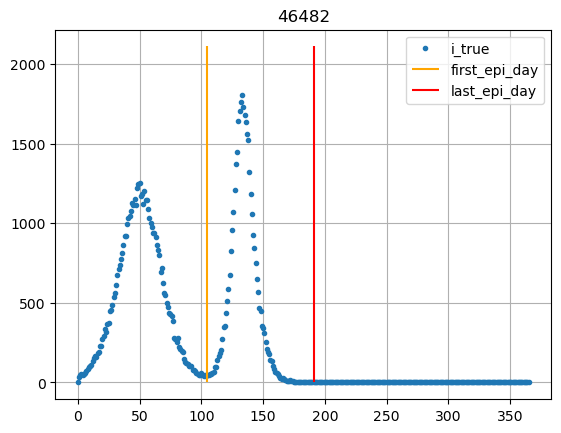

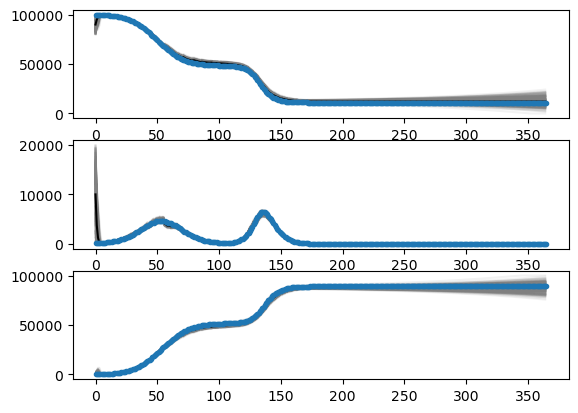

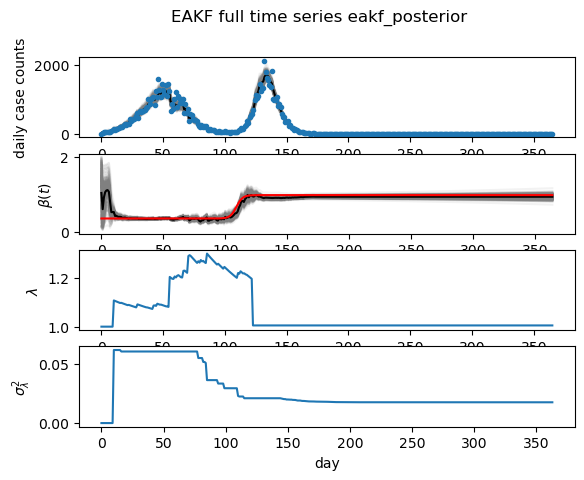

In [16]:
from epyfilter import model_da, eakf, enks, posterior_checks
from numpy.random import uniform
from epyfilter.c2b2.run_eakf import compute_posterior_checks

test_params = [46482, 69090, 16738]

pp = test_params[0]

import pickle

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")

days_df = pd.read_csv("compute_days.csv")
last_epi_day = days_df.loc[days_df.param == 46482, "last_epi_day"].values[0]
first_epi_day = days_df.loc[days_df.param == 46482, "first_epi_day"].values[0]

fig, ax = plt.subplots()
ax.plot(data.i_true, '.', label='i_true')
ax.vlines(first_epi_day, 0, max(data.i), color='orange', label='first_epi_day')
ax.vlines(last_epi_day, 0, max(data.i), color='red', label='last_epi_day')
ax.grid()
ax.legend()
ax.set_title(pp)


model = model_da.SIR_model(data)

prior = {
    "beta": {
        "dist": uniform,
        "args": {
            "low": 0.1,
            "high": 2.0,
        },
    },
    "t_I": {
        "dist": "constant",
    },
}

kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf.filter(prior)
percentiles = np.arange(2.5, 100, 2.5)
kf.compute_reliability(percentiles)
kf.compute_beta_reliability(percentiles)

kf.plot_posterior()

ks = enks.EnsembleSquareRootSmoother(kf)
ks.smooth(window_size=10, plot=False)
ks.compute_reliability(percentiles)
ks.compute_beta_reliability(percentiles)

In [17]:
posterior_checks.crps(ks, first_epi_day)

63.280324669817325

In [18]:
len(ks.x_list)

356

## Test why CI is 0 for no inflation

In [19]:
days_df = pd.read_csv("compute_days.csv")
days_df.loc[days_df.param == 46482]

,param,late_day,peak1,peak2,last_epi_day,first_epi_day
0,46482,119,51,131,191,105


In [20]:
pp = 46482
eakf_metrics_df.loc[eakf_metrics_df.param == pp]


,method,rt_rmse_up_to_last_epi_day,rt_rmse_last_epi_day,avg_w2_up_to_last_epi_day,avg_w2_last_epi_day,avg_kl_up_to_last_epi_day,avg_kl_last_epi_day,in_ci_last_epi_day,crps_last_epi_day,rt_rmse_up_to_first_epi_day,rt_rmse_first_epi_day,avg_w2_up_to_first_epi_day,avg_w2_first_epi_day,avg_kl_up_to_first_epi_day,avg_kl_first_epi_day,in_ci_first_epi_day,crps_first_epi_day,param
0,adaptive inflation,0.346837,0.208923,0.752354,0.113138,0.980524,0.106043,0.76,0.169398,0.372755,0.378227,0.718416,0.718675,0.976584,0.960194,1.0,1.194547,46482
1,fixed inflation,0.470807,0.281239,1.108278,0.148160,5.544861,0.148249,0.04,0.231532,0.324684,0.462354,0.851867,1.106781,1.606580,3.991537,0.0,1.554124,46482
2,no inflation,1.236706,2.529351,1.298766,0.537245,9.201152,6.102437,0.00,0.410941,0.297479,0.439387,1.029738,1.166657,2.743090,3.651745,0.0,1.580393,46482
3,smooth inflation,0.163637,0.209092,0.353428,0.140692,0.805754,0.760793,0.77,0.231259,0.101859,0.349259,0.374711,0.279258,0.999070,0.116600,0.0,66.876930,46482


Text(0.5, 1.0, '46482')

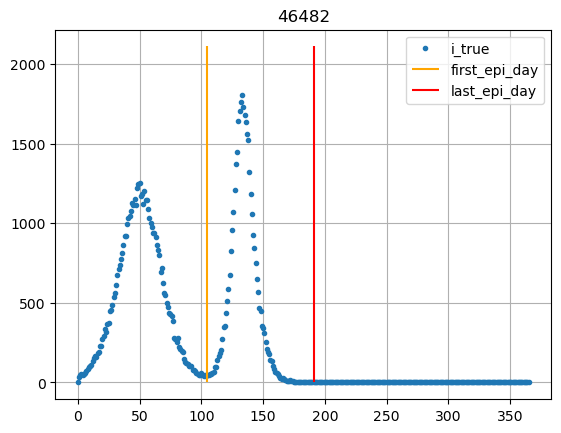

In [21]:
import pickle

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")
days_df = pd.read_csv("compute_days.csv")
zero_days = np.where(data.i_true == 0)
last_epi_day = days_df.loc[days_df.param == 46482, "last_epi_day"].values[0]
first_epi_day = days_df.loc[days_df.param == 46482, "first_epi_day"].values[0]

fig, ax = plt.subplots()
ax.plot(data.i_true, '.', label='i_true')
ax.vlines(first_epi_day, 0, max(data.i), color='orange', label='first_epi_day')
ax.vlines(last_epi_day, 0, max(data.i), color='red', label='last_epi_day')
ax.grid()
ax.legend()
ax.set_title(pp)

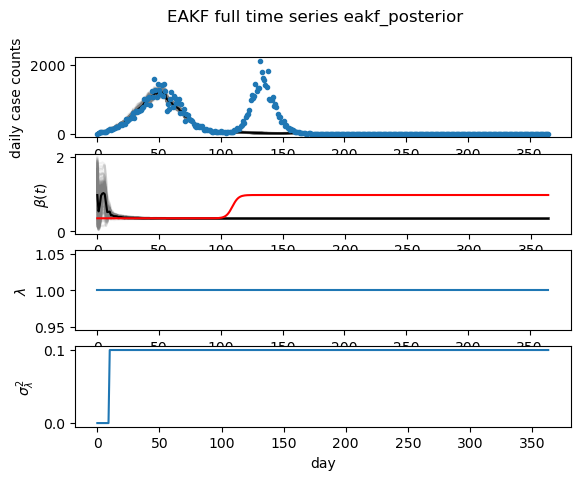

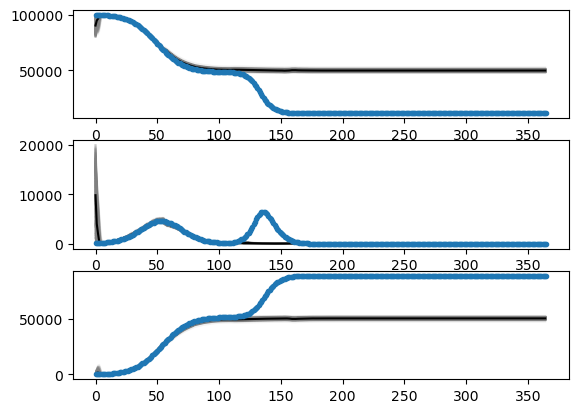

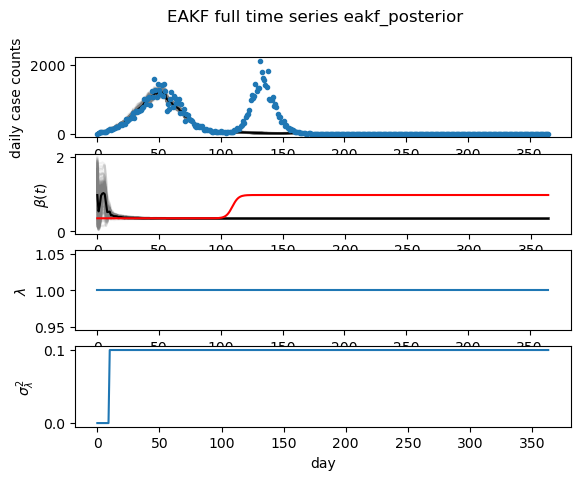

In [22]:
from epyfilter import model_da, eakf, enks, posterior_checks
from numpy.random import uniform
from epyfilter.c2b2.run_eakf import compute_posterior_checks

pkl_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data"

pickle_file = os.path.join(pkl_dir, f"{pp}_synthetic_data.pkl")
with open(pickle_file, "rb") as file:
    data = pickle.load(file)

model = model_da.SIR_model(data)

prior = {
    "beta": {
        "dist": uniform,
        "args": {
            "low": 0.1,
            "high": 2.0,
        },
    },
    "t_I": {
        "dist": "constant",
    },
}

kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf.filter(prior, inf_method="none")
percentiles = np.arange(2.5, 100, 2.5)
kf.compute_reliability(percentiles)
kf.compute_beta_reliability(percentiles)

kf.plot_posterior()

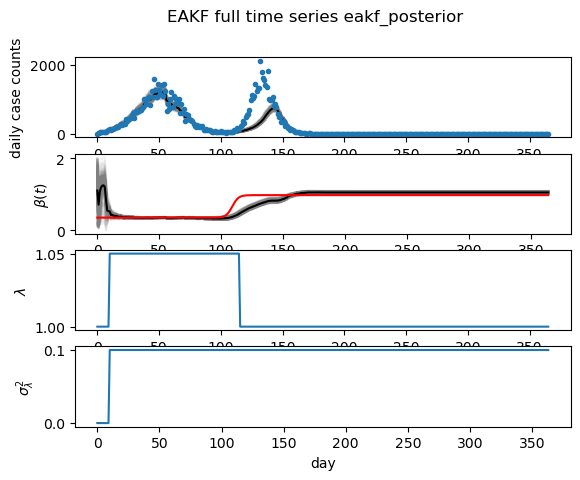

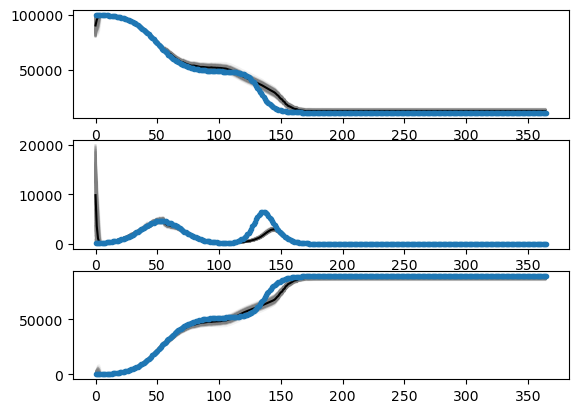

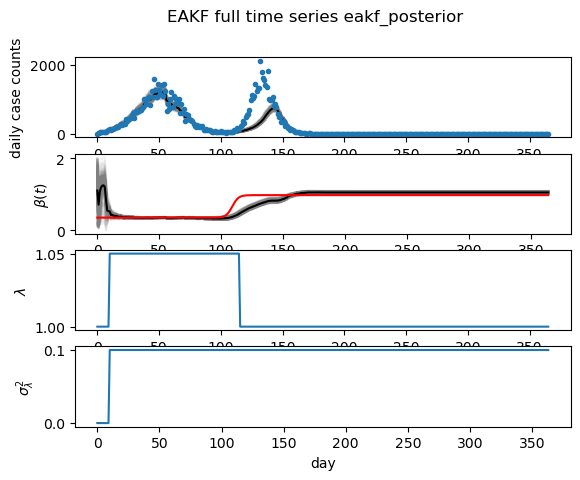

In [23]:
kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf.filter(prior, inf_method="constant", lam_fixed=1.05)
percentiles = np.arange(2.5, 100, 2.5)
kf.compute_reliability(percentiles)
kf.compute_beta_reliability(percentiles)

kf.plot_posterior()

In [24]:
beta_post = np.array([θ.beta for θ in kf.θ_list])
print(np.mean(beta_post[first_epi_day]))
print(np.var(beta_post[first_epi_day]))

0.3377682154171303
0.000558508553367651


In [25]:
percentile=95
post_betas = np.asarray([θ.beta * θ.t_I for θ in kf.θ_list])
quantiles = [(1 - percentile / 100) / 2, 1 - (1 - percentile / 100) / 2]
quantiles_beta = np.quantile(post_betas, q=quantiles, axis=1)
lower = quantiles_beta[0, :]
upper = quantiles_beta[1, :]

kf.data.beta[first_epi_day] * kf.data.t_I

1.8199540371651894

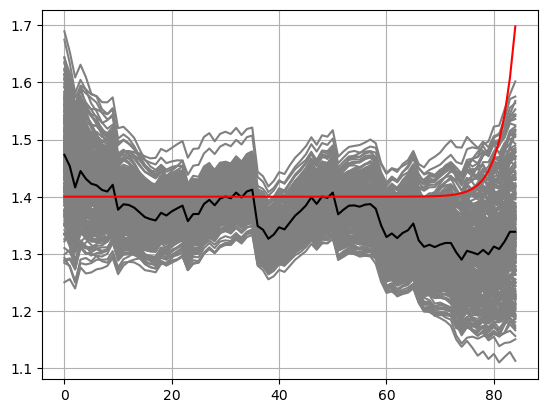

In [26]:
fig, ax = plt.subplots()

ax.plot(post_betas[20:first_epi_day,:], color='gray')
ax.plot(np.mean(post_betas[20:first_epi_day,:], axis=1), color='black')
ax.plot(kf.data.beta[20:first_epi_day]* kf.data.t_I, color='red')

ax.grid()

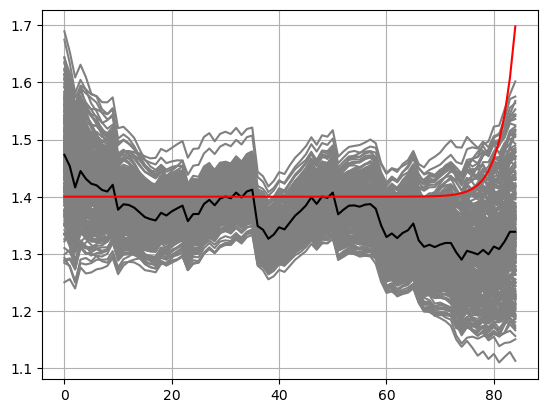

In [27]:
fig, ax = plt.subplots()

ax.plot(post_betas[20:first_epi_day,:], color='gray')
ax.plot(np.mean(post_betas[20:first_epi_day,:], axis=1), color='black')
ax.plot(kf.data.beta[20:first_epi_day]* kf.data.t_I, color='red')

ax.grid()

In [28]:
np.mean(post_betas[first_epi_day,:])

1.3510728616685213

In [29]:
posterior_checks.rt_rmse(kf, True, int(first_epi_day))

0.354322070632321

## Distribution of performance metrics

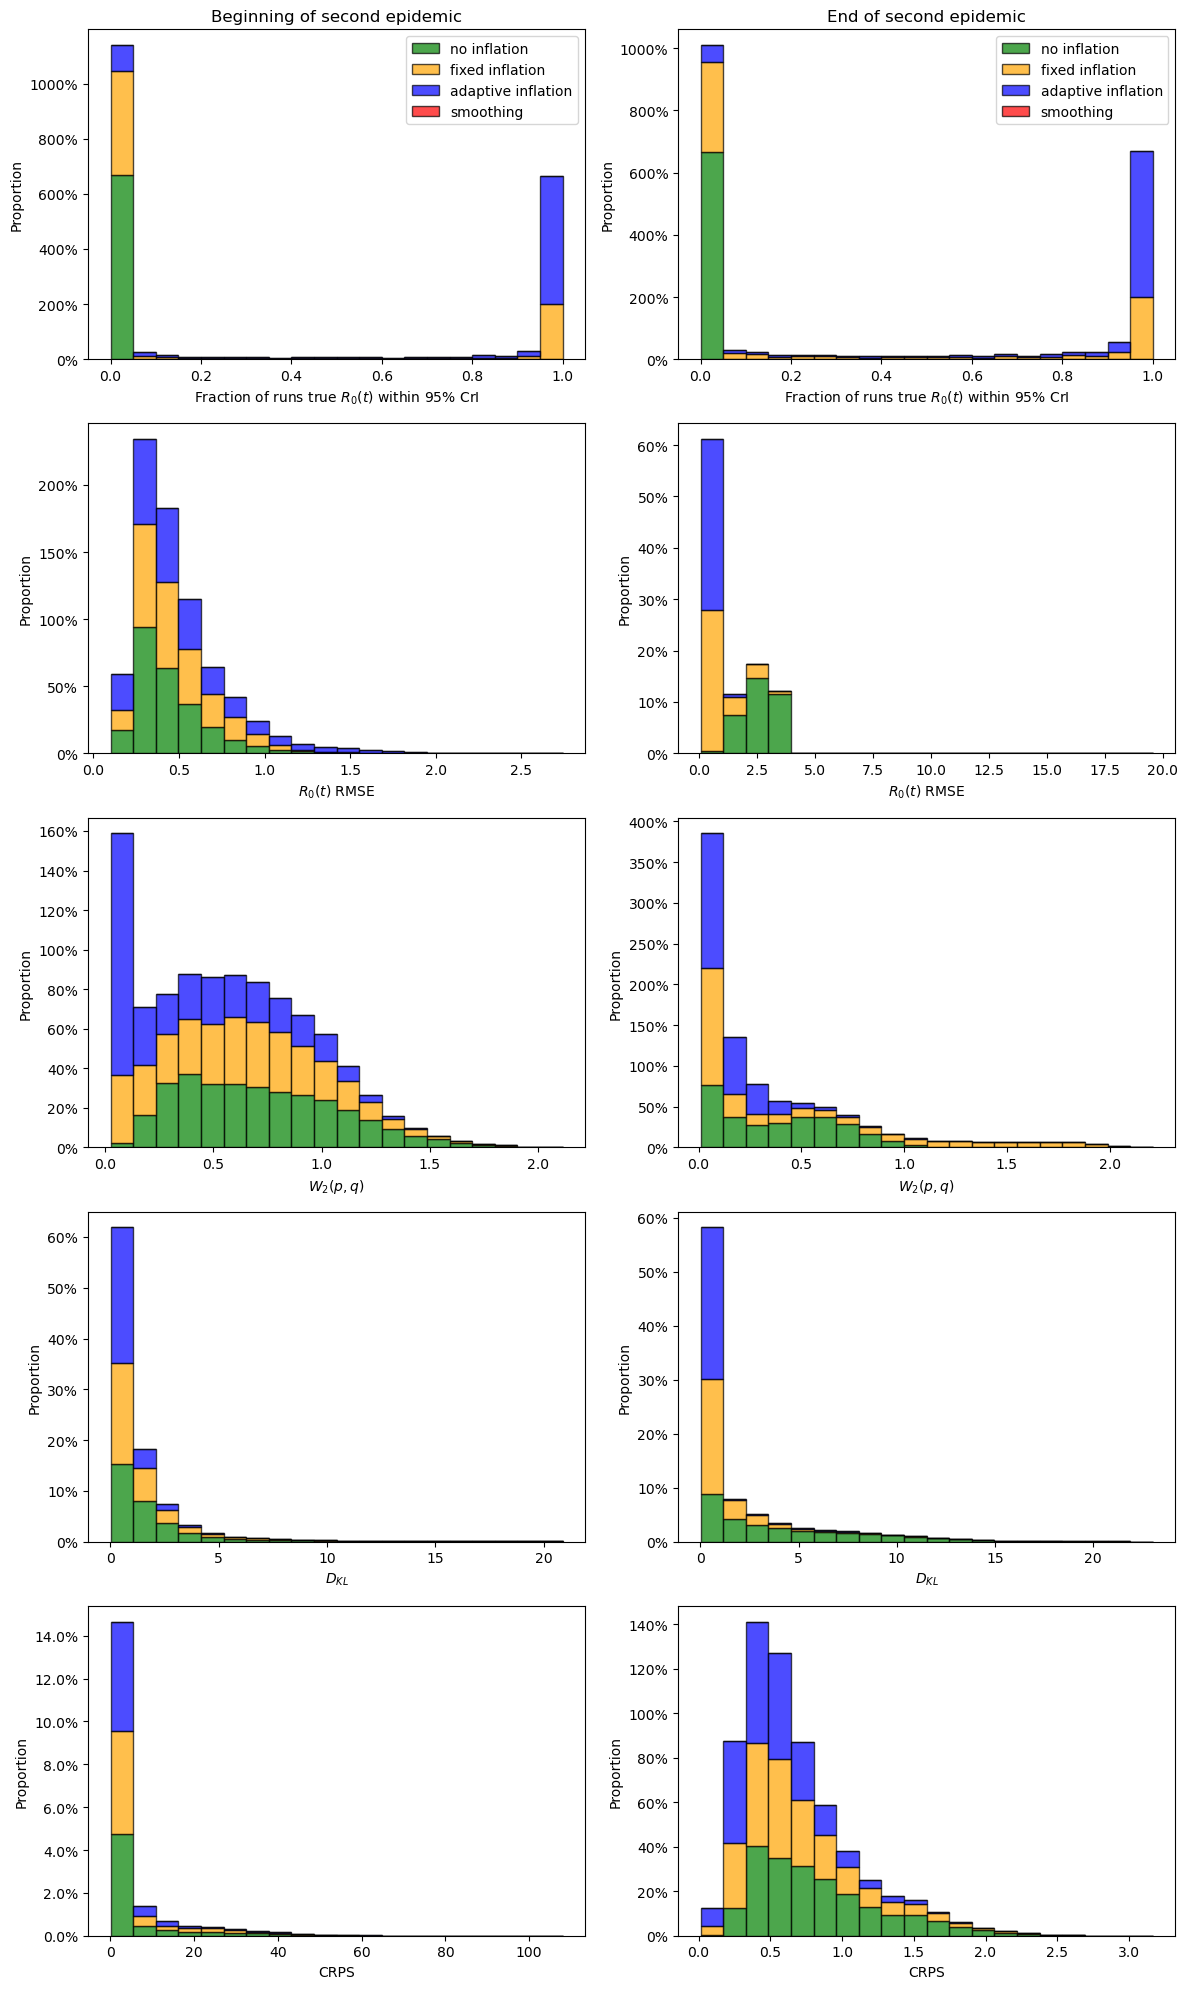

In [64]:
cols_titles = {
    'in_ci_first_epi_day'   : r'Fraction of runs true $R_0(t)$ within 95% CrI',
    'rt_rmse_first_epi_day' : r'$R_0(t)$ RMSE',
    'avg_w2_first_epi_day'  : r'$W_2(p,q)$',
    'avg_kl_first_epi_day'  : r'$D_{KL}$',
    'crps_first_epi_day'    : 'CRPS',
    'in_ci_last_epi_day'   : r'Fraction of runs true $R_0(t)$ within 95% CrI',
    'rt_rmse_last_epi_day' : r'$R_0(t)$ RMSE',
    'avg_w2_last_epi_day'  : r'$W_2(p,q)$',
    'avg_kl_last_epi_day'  : r'$D_{KL}$',
    'crps_last_epi_day'    : 'CRPS'
}

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

for (col, title), ax in zip(cols_titles.items(), axes.flatten('F')):
    no_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "no inflation", col]
    fix_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "fixed inflation", col]
    adapt_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", col]
    smooth_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "smooth", col]
    
    ax.hist([no_ci, fix_ci, adapt_ci, smooth_ci],
            histtype='bar',
            bins=20,
            color=['green', 'orange', 'blue', 'red'],
            label=["no inflation", "fixed inflation", "adaptive inflation", "smoothing"],
            edgecolor='black',
            alpha=0.7,
            stacked=True,
            density=True,
           )

    # ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_xlabel(f'{title}')
    ax.set_ylabel('Proportion')
    if ax in axes[0]:  # Add legend only to the top row
        ax.legend(fontsize=10)
    
    if ax == axes[0,0]:
        ax.set_title("Beginning of second epidemic")
    if ax == axes[0,1]:
        ax.set_title("End of second epidemic")

plt.tight_layout()
plt.show()

# Look for examples params for figures

In [45]:
len(np.unique(eakf_metrics_df.param))

47871

In [ ]:
table_cols = [
    'method',
    'in_ci_last_epi_day',
    'rt_last_epi_day_rmse',
    'avg_w2_last_epi_day',
    'avg_kl_last_epi_day',
]

max_params = merge_df.iloc[merge_df[table_cols].groupby("method").idxmax().values.flatten()].param.unique()
min_params = merge_df.iloc[merge_df[table_cols].groupby("method").idxmin().values.flatten()].param.unique()

# append the min and max params for epiestim
epiesim_max_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax().values].param.unique()
epiesim_min_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin().values].param.unique()

max_params = np.unique(np.append(max_params, epiesim_max_params))
min_params = np.unique(np.append(min_params, epiesim_min_params))

In [ ]:
# params that are closest to the mean metric value

mean_df = merge_df[table_cols].groupby('method').mean()
mean_df.columns = mean_df.columns + "_mean"

mean_diff_df = merge_df[table_cols + ['param']].merge(mean_df, on="method")
mean_diff_df['in_ci_last_epi_day'] = np.abs(mean_diff_df['in_ci_last_epi_day'] - mean_diff_df['in_ci_last_epi_day_mean'])
mean_diff_df['rt_last_epi_day_rmse'] = np.abs(mean_diff_df['rt_last_epi_day_rmse'] - mean_diff_df['rt_last_epi_day_rmse_mean'])
mean_diff_df['avg_w2_last_epi_day'] = np.abs(mean_diff_df['avg_w2_last_epi_day'] - mean_diff_df['avg_w2_last_epi_day_mean'])
mean_diff_df['avg_kl_last_epi_day'] = np.abs(mean_diff_df['avg_kl_last_epi_day'] - mean_diff_df['avg_kl_last_epi_day_mean'])

mean_params = mean_diff_df.iloc[mean_diff_df[table_cols + ['param']].groupby("method").idxmin().values.flatten()].param.unique()

# append epiestim mean params
epiestim_mean_df = epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].mean()
mean_params = np.append(mean_params, [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param for tt in table_cols[1:]])

In [ ]:
mean_diff_df[table_cols + ['param']].groupby("method").idxmin()

In [ ]:
mean_diff_df.iloc[17260].param

In [ ]:
max_df = merge_df[table_cols].groupby("method").idxmax().reset_index()
max_epi_df = pd.DataFrame(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax()).T
max_epi_df["method"] = "epiestim"
max_df = pd.concat([max_df, max_epi_df])
max_df["example"] = "max"

min_df = merge_df[table_cols].groupby("method").idxmin().reset_index()
min_epi_df = pd.DataFrame(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin()).T
min_epi_df["method"] = "epiestim"
min_df = pd.concat([min_df, min_epi_df])
min_df["example"] = "min"

mean_df = mean_diff_df[table_cols + ['param']].groupby("method").idxmin().reset_index()
dd = {tt : [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param] for tt in table_cols[1:]}
mean_epi_df = pd.DataFrame.from_dict(dd)
mean_epi_df["method"] = "epiestim"
mean_df = pd.concat([mean_df, mean_epi_df])
mean_df["example"] = "mean"
mean_df.drop(["param"], axis=1, inplace=True)

list_df = pd.concat([max_df, min_df, mean_df])
list_df.to_csv("example_params_for_plots.csv", index=False)

In [ ]:
params = np.append(min_params, max_params)
params = np.append(params, mean_params)
params = np.unique(params)
params

In [ ]:
plot_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"

files = os.listdir(plot_dir)
done_params = [int(f.split("_")[0]) for f in files if "epiEstim_for_plot.csv" in f]

to_do_params = list(set(params) - set(done_params))
to_do_params

In [ ]:
import re
import pickle
from matplotlib.backends.backend_pdf import PdfPages


plot_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"
files = os.listdir(plot_dir)

param_df = pd.read_csv("param_list.csv")

def open_pickle_rt(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    if smooth:
        array = np.array([θ.beta*θ.t_I for θ in data.θ_lag_list])
    else:
        array = np.array([θ.beta*θ.t_I for θ in data.θ_list])
    return array

def open_pickle_data(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    array = np.array([x.i for x in data.x_list])
    data = data.data.i
    return array, data

def compute_ci_mean(array, confidence_level=95):
    ci = np.percentile(array, [100 - confidence_level, confidence_level], axis=1)
    mean = np.mean(array, axis=1)
    return ci, mean

def get_truth(pickle_file, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data.data.rt


last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")
pdf_file = f"{plot_dir}/example_params_rt_obs_metrics.pdf"

adapt_params = [55685, 98225, 100184, 85084, 190, 97638, 57072, 46482, 66815, 5863, 43056]

adapt_titles = {
    55685  : r"Best calibration",
    98225  : r"Worst RMSE",
    100184 : r"Worst $D_{KL}$",
    85084  : r"Worst $W^2$",
    26094  : r"Worst calibration",
    190    : r"Best RMSE",
    97638  : r"Best $D_{KL}$",
    57072  : r"Best $W^2$",
    46482  : r"Avg calibration",
    66815  : r"Avg RMSE",
    5863   : r"Avg $D_{KL}$",
    43056  : r"Avg $W^2$",
}

pdf_file = f"{plot_dir}/example_adapt_params_rt_obs_metrics.pdf"
with PdfPages(pdf_file) as pdf:
    for pp in tqdm(adapt_params):
    # for pp in tqdm(params):
        epiestim_df = pd.read_csv(f"{plot_dir}/{pp}_epiEstim_for_plot.csv")
        epiestim_df = epiestim_df.loc[epiestim_df.window == 8]
        last_day = last_day_df.loc[last_day_df.param == pp, 'last_epidemic_day'].values[0]
        for run in range(1):
            no_pickle_file = f"{pp}_no_inflation_run_{run}.pkl"
            fixed_pickle_file = f"{pp}_fixed_inflation_run_{run}.pkl"
            adapt_pickle_file = f"{pp}_adaptive_inflation_run_{run}.pkl"
            smooth_pickle_file = f"{pp}_smooth_inflation_run_{run}.pkl"

            # get rt estimates and truth
            truth = get_truth(no_pickle_file)
            ci_no, mean_no = compute_ci_mean(open_pickle_rt(no_pickle_file))
            ci_fixed, mean_fixed = compute_ci_mean(open_pickle_rt(fixed_pickle_file))
            ci_adapt, mean_adapt = compute_ci_mean(open_pickle_rt(adapt_pickle_file))
            ci_smooth, mean_smooth = compute_ci_mean(open_pickle_rt(smooth_pickle_file, smooth=True))

            i_no, i_obs = open_pickle_data(no_pickle_file)
            ci_i_no, mean_i_no = compute_ci_mean(i_no)
            i_fixed, _ = open_pickle_data(fixed_pickle_file)
            ci_i_fixed, mean_i_fixed = compute_ci_mean(i_fixed)
            i_adapt, _ = open_pickle_data(adapt_pickle_file)
            ci_i_adapt, mean_i_adapt = compute_ci_mean(i_adapt)
            i_smooth, _ = open_pickle_data(smooth_pickle_file)
            ci_i_smooth, mean_i_smooth = compute_ci_mean(i_smooth)

            fig, ax = plt.subplots(2,2)
            fig.suptitle(adapt_titles[pp])
            fig.set_figheight(12)
            fig.set_figwidth(16)

            # plot Rt
            ax[0,0].fill_between(np.arange(ci_no.shape[1]), ci_no[0,:], ci_no[1,:], color='blue', alpha=0.3)
            ax[0,0].plot(mean_no, color="blue", label=r"EAKF with no inflation")

            ax[0,0].fill_between(np.arange(ci_fixed.shape[1]), ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
            ax[0,0].plot(mean_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax[0,0].fill_between(np.arange(ci_adapt[0,:].shape[0]), ci_adapt[0,:], ci_adapt[1,:], color='yellow', alpha=0.3)
            ax[0,0].plot(mean_adapt, color="orange", label=r"EAKF with adaptive inflation")

            ax[0,0].fill_between(np.arange(ci_smooth.shape[1]), ci_smooth[0,:], ci_smooth[1,:], color='green', alpha=0.3)
            ax[0,0].plot(mean_smooth, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

            ax[0,0].fill_between(epiestim_df.day, epiestim_df['2.5%'], epiestim_df['97.5%'], color='grey', alpha=0.3)
            ax[0,0].plot(epiestim_df.day, epiestim_df['mean'], color='black', label=r"EpiEstim")

            ax[0,0].vlines(last_day, 0.01, ax[0,0].get_ylim()[1], color='steelblue', label='last epi day')

            ax[0,0].plot(truth, color="red", label=r"Synthetic truth")

            ax[0,0].set_xlabel("day", fontsize=12)
            ax[0,0].set_ylabel(r"$R_t$", fontsize=12)

            ax[0,0].legend()
            ax[0,0].grid()

            param_dict = param_df.iloc[pp-1][['rt_0', 'rt_1', 'k', 'midpoint']]
            ax[0,0].set_title(f"param {pp} run {run} {round(param_dict,3).to_dict()}")

            # table for metrics
            pp_kf_df = merge_df.loc[merge_df.param == pp, table_cols].round(3)
            pp_ep_df = epiestim_metrics_df.loc[(epiestim_metrics_df.window == 8) & (epiestim_metrics_df.param == pp), table_cols[1:]].round(3)
            pp_ep_df['method'] = 'epiestim'

            pp_df = pd.concat([pp_kf_df, pp_ep_df])
            custom_order = ['no inflation', 'fixed inflation', 'adaptive inflation', 'smooth inflation', 'epiestim']
            pp_df['method'] = pd.Categorical(pp_df['method'], categories=custom_order, ordered=True)
            pp_df = pp_df.sort_values(by='method')

            ax[0,1].axis('off')
            table = ax[0,1].table(cellText=pp_df.values, colLabels=pp_df.columns, loc='center')
            table.set_fontsize(24)
            table.scale(1.3, 1.3)

            # plot i
            ax[1,0].fill_between(np.arange(ci_i_no.shape[1]), ci_i_no[0,:], ci_i_no[1,:], color='blue', alpha=0.3)
            ax[1,0].plot(mean_i_no, color="blue", label=r"EAKF with no inflation")

            ax[1,0].fill_between(np.arange(ci_i_fixed.shape[1]), ci_i_fixed[0,:], ci_i_fixed[1,:], color='purple', alpha=0.3)
            ax[1,0].plot(mean_i_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax[1,0].fill_between(np.arange(ci_i_adapt[0,:].shape[0]), ci_i_adapt[0,:], ci_i_adapt[1,:], color='yellow', alpha=0.3)
            ax[1,0].plot(mean_i_adapt, color="orange", label=r"EAKF with adaptive inflation")

            ax[1,0].fill_between(np.arange(ci_i_smooth.shape[1]), ci_i_smooth[0,:], ci_i_smooth[1,:], color='green', alpha=0.3)
            ax[1,0].plot(mean_i_smooth, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

            ax[1,0].vlines(last_day, 0.01, ax[1,0].get_ylim()[1], color='steelblue', label='last epi day')

            ax[1,0].plot(i_obs, '.', color='red', label='observations')

            ax[1,0].set_xlabel("day", fontsize=12)
            ax[1,0].set_ylabel(r"daily case counts", fontsize=12)

            ax[1,0].legend()
            ax[1,0].grid()


            ax[1,1].axis('off')

            pdf.savefig(fig)
            plt.close()

            # plt.savefig(f'rt.svg', format='svg', bbox_inches='tight', transparent=True)

        

# Compute correlations with params

In [ ]:
param_df = pd.read_csv("param_list.csv")
param_df["param"] = param_df.index

In [ ]:
param_df['early_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(1.01*param_df.rt_0 - param_df.rt_0)-1) + param_df.midpoint
param_df['late_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(0.99*param_df.rt_1 - param_df.rt_0)-1) + param_df.midpoint
param_df['day_diff'] = param_df['late_day'] - param_df['early_day']
param_df['rt_diff'] = param_df['rt_1'] - param_df['rt_0']

In [ ]:
merge_df = merge_df.merge(param_df, on="param")
epiestim_metrics_df = epiestim_metrics_df.merge(param_df, on="param")

In [ ]:
metric_cols = ['rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl', 'in_ci',
       'ens_var', 'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day', 'avg_w2_last_epi_day', 'avg_kl_last_epi_day']
param_cols = ['rt_0', 'rt_1', 'midpoint', 'k', 'early_day', 'late_day', 'day_diff', 'rt_diff']

In [ ]:
from sklearn.manifold import TSNE
X = param_df.loc[param_df.param.isin(merge_df.param), ['rt_0', 'rt_1', 'midpoint', 'k']]
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Add legends and labels
plt.title('t-SNE Plot of Parameters for Synthetic Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns

correlation_matrix = merge_df[metric_cols + param_cols].corr()
correlation_matrix_subset = correlation_matrix.loc[correlation_matrix.index.isin(param_cols),metric_cols]

# Create a heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', linewidths=.5, square=True)

# Customize the plot
plt.title('Correlation Heatmap')
plt.show()

correlation_matrix_subset.to_csv("correlation.csv", index=False)

In [ ]:
# move files
# files = glob.glob(dir + '/*epiEsim_plots.pdf')

# new_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/pdf_archive/"
# for f in tqdm(files):
#     new_path = new_dir + os.path.basename(f)
#     os.rename(f, new_path)


In [ ]:
merge_df

In [ ]:
import seaborn as sns

_methods = ['adaptive inflation', 'fixed inflation', 'no inflation', 'smooth']
sns.relplot(data=eakf_metrics_df, x='in_ci_last_day', y='ens_var_last_day', hue='method', hue_order=_methods, aspect=1.61)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
no_ci = merge_df.loc[merge_df["method"] == "no inflation", "in_ci_last_day"]
fix_ci = merge_df.loc[merge_df["method"] == "fixed inflation", "in_ci_last_day"]
adapt_ci = merge_df.loc[merge_df["method"] == "adaptive inflation", "in_ci_last_epi_day"]
smooth_ci = merge_df.loc[merge_df["method"] == "smooth", "in_ci_last_day"]
# ax.hist(no_ci, bins=20, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=20, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
ax.hist(adapt_ci, bins=20, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=20, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.xlabel('Proportion of runs in 95% CI')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# no_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "no inflation", "ens_var_last_day"]
# # fix_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "fixed inflation", "ens_var_last_day"]
# adapt_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# smooth_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "smooth", "ens_var_last_day"]

# # ax.hist(no_ci, bins=5, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=5, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
# ax.hist(adapt_ci, bins=5, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=5, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

# # ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
# plt.title('Histogram Example')
# plt.xlabel('Ensemble Variance')
# plt.ylabel('Frequency')
# plt.legend()

In [ ]:
# from scipy.stats.kde import gaussian_kde

# x = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "in_ci_last_day"]
# y = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# Z, xedges, yedges = np.histogram2d(x, y,bins=5)
# plt.pcolormesh(xedges, yedges, Z.T)
# plt.colorbar()



# Compute last day

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import pickle
from epyfilter import simulate_data

from scipy.signal import argrelmin

from epyfilter.compute_days import compute_last_epi_day, compute_first_epi_day, compute_peaks
from matplotlib.backends.backend_pdf import PdfPages


good_param_df = pd.read_csv("good_param_list.csv")
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

last_day_array = np.empty(shape=(len(pickle_list), 2))

In [ ]:
sample_params = good_param_df.sample(100).param.tolist()

In [ ]:
for i in range(len(sample_params)):
    pp = sample_params[i]
    data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")

    zero_days = np.where(data.i_true == 0)
    last_epi_day = compute_last_epi_day(data)
    first_epi_day = compute_first_epi_day(data)

    fig, ax = plt.subplots()
    ax.plot(data.i_true, '.', label='i_true')
    ax.vlines(first_epi_day, 0, max(data.i), color='orange', label='first_epi_day')
    ax.vlines(last_epi_day, 0, max(data.i), color='red', label='last_epi_day')
    ax.grid()
    ax.legend()
    ax.set_title(pp)


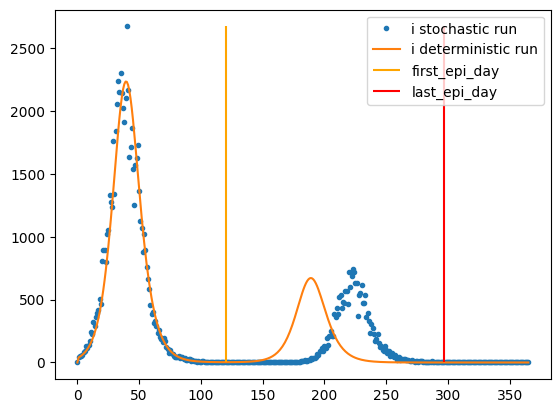

In [7]:
pp = 89430
data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")
first_epi_day = compute_first_epi_day(data)
last_epi_day = compute_last_epi_day(data)
det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)

fig, ax = plt.subplots()
# ax.plot(data.i_true, '.', label='i_true')
ax.plot(data.i, '.', label='i stochastic run')
ax.plot(det_data.i, '-', label='i deterministic run')
ax.vlines(first_epi_day, 0, max(data.i), color='orange', label='first_epi_day')
ax.vlines(last_epi_day, 0, max(data.i), color='red', label='last_epi_day')
ax.legend()

# Fix last epi day

In [22]:
last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")

In [44]:
to_do_params = []
last_epi_days = []

for index, row in tqdm(last_day_df.iterrows()):
    param = row['param']
    last_epi_day = row['last_epidemic_day']
    pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
    data = open_pickle(pp)
    zero_days = np.where(data.i_true == 0)[0]
    if len(zero_days) == 1:  # never reached 0
        last_day = len(data.i_true)
    else:
        first_zero_day = zero_days[1]
        non_zero_days = np.where(data.i_true > 10)[0]
        if np.any(non_zero_days > first_zero_day):
            last_days = zero_days[zero_days > np.max(non_zero_days)]
            if len(last_days) == 0:
                last_day = len(data.i_true)
            else:
                last_day = last_days[0]
        else:
            last_day = first_zero_day
    if last_epi_day != last_day:
        to_do_params.append(param)
        last_epi_days.append(last_day)
        

47871it [1:23:21,  9.57it/s]


In [57]:
pd.DataFrame(np.array((to_do_params, last_epi_days)).T, columns=["param", "last_epi_day"]).to_csv("to_do_params_last_epi_day.csv", index=False)

In [38]:
# for param in to_do_params[0:10]:
#     pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
#     data = open_pickle(pp)
#     last_epi_day = last_day_df.loc[last_day_df.param == param, 'last_epidemic_day'].values[0]
#     plt.plot(data.i_true, '.')
#     plt.axvline(x = last_epi_day)

array([  0, 162, 173, 174, 175, 176, 177, 179, 182, 184, 186])

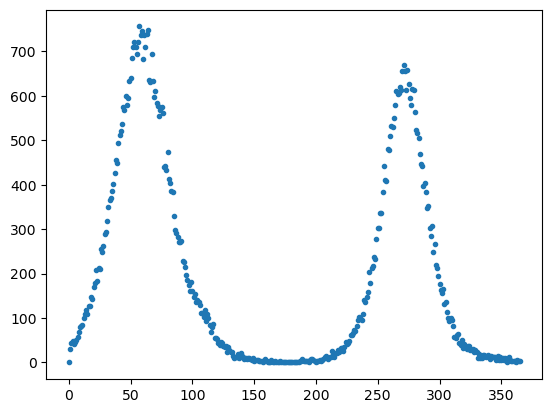

In [29]:
plt.plot(data.i_true, '.')
np.where(data.i_true == 0)[0]

In [22]:
import pickle
from epyfilter import simulate_data
from tqdm import tqdm

# good_param_df = pd.read_csv("good_param_list.csv")
# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def compute_late_day(data):
    beta_1 = data.rt_1 / data.t_I
    beta_0 = data.rt_0 / data.t_I
    late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
    late_day = int(late_day)
    return late_day

def compute_peaks(data):
    det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)
    peak_days, = np.where(np.diff(np.sign(np.diff(det_data.i_true))) == -2)  # days where it increases before then decreases
    peak_days = peak_days[:2]  # just take first two days
    return peak_days

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

In [27]:
# data_files = glob.glob(dir + '/*_data_distribution.csv')
# done_params = [int(os.path.basename(f).split("_")[0]) for f in data_files]
# todo_params = list(set(good_param_df.param) - set(done_params))

# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in todo_params]

In [28]:
# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_synthetic_data.pkl" for param in params]

In [24]:
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_synthetic_data.pkl" for param in to_do_params]

In [25]:
for pp in tqdm(pickle_list):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    data_distribution_df = pd.DataFrame(data.data_distribution, columns=[f"sample{x}" for x in range(1,301)])
    data_distribution_df["day"] = range(len(data_distribution_df))
    data_distribution_df["late_day"] = compute_late_day(data)
    peaks = compute_peaks(data)
    data_distribution_df["peak1"] = peaks[0]
    data_distribution_df["peak2"] = peaks[1]
    
    data_distribution_df.to_csv(f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_data_distribution.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


In [26]:
len(glob.glob('/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/' + '/*_data_distribution.csv'))

52

# Fix Single Epidemics

In [7]:
pickles = glob.glob(dir + '/*.pkl')

In [8]:
import pickle
def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [3:04:18<00:00,  9.06it/s]


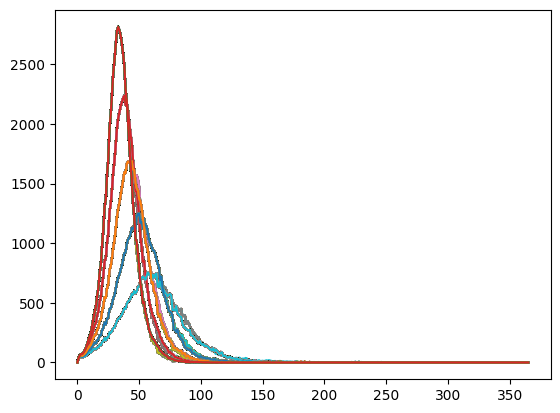

In [10]:
from tqdm import tqdm
from scipy.signal import find_peaks

bad_params = []
for file in tqdm(pickles):
    data = open_pickle(file)

    window_size = 10  # Adjust this window size as needed
    smoothed_data = np.convolve(data.i_true, np.ones(window_size) / window_size, mode='valid')
    peaks, _ = find_peaks(smoothed_data, height=100, prominence=10)
    if len(peaks) < 2:
        bad_params.append(file)
        plt.plot(data.i_true)

In [11]:
len(bad_params)

52314

In [14]:
pd.DataFrame(bad_params).to_csv("one_epidemic_curve.csv", index=False)

In [18]:
bad_metric_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{os.path.basename(b).split('_')[0]}_eakf_metrics.csv" for b in bad_params]

In [21]:
dfs = []
for file in tqdm(files):
    if file not in bad_metric_files:
        df = pd.read_csv(file)
        param = os.path.basename(file).split("_")[0]
        df["param"] = param
        dfs.append(df)

good_combined_df = pd.concat(dfs, ignore_index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [07:22<00:00, 226.36it/s]


In [22]:
good_combined_df[["method", "rt_peak_rmse", "rt_rmse", "data_rmse", "avg_w2", "avg_kl", "in_ci"]].groupby("method").mean()

,rt_peak_rmse,rt_rmse,data_rmse,avg_w2,avg_kl,in_ci
method,,,,,,
adaptive inflation,0.084815,0.374231,47.154245,0.642203,0.952536,0.662593
fixed inflation,0.044096,0.599377,68.936821,0.811197,3.306851,0.172927
no inflation,0.024710,1.763012,117.320087,0.988873,7.159461,0.000000
smooth,0.043557,0.253248,58.496632,0.383990,0.968416,0.543410


Text(0, 0.5, 'Count')

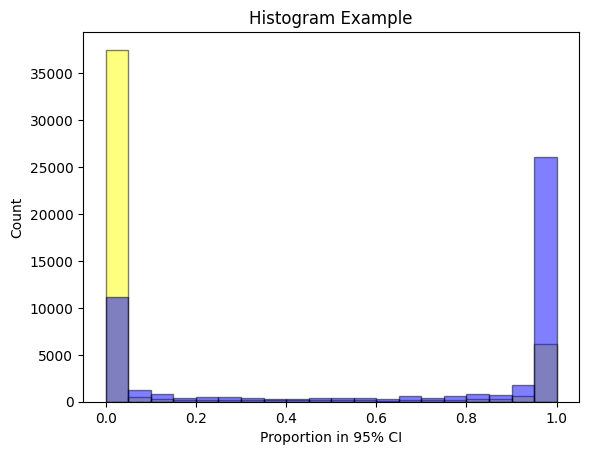

In [23]:
plt.hist(good_combined_df.loc[good_combined_df["method"] == "fixed inflation", "in_ci"], bins=20, color='yellow', edgecolor='black', alpha=0.5)
plt.hist(good_combined_df.loc[good_combined_df["method"] == "adaptive inflation", "in_ci"], bins=20, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histogram Example')
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Count')

In [42]:
pd.DataFrame(good_combined_df.param.unique(), columns=["param"]).to_csv("good_param_list.csv", index=False)

In [45]:
df = pd.read_csv("good_param_list.csv")
pickle_files = df.iloc[1:1000, 0]

In [46]:
pickle_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{p}_synthetic_data.pkl" for p in pickle_files]

In [51]:
4788/200 * 3

71.82000000000001

In [55]:
files = glob.glob(dir + '/*_for_epiestim.csv')

In [58]:
pd.read_csv(files[0])

,rt,i,prop_S
0,1.3,33.742320,0.99869
1,1.3,42.500996,0.99826
2,1.3,45.972273,0.99778
3,1.3,38.297496,0.99736
4,1.3,38.854358,0.99690
...,...,...,...
360,4.7,0.000000,0.58860
361,4.7,0.396479,0.58860
362,4.7,0.000000,0.58860
363,4.7,0.000000,0.58860
